In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
random_state = 2020

train_df = pd.read_csv('../data/final/train_imputed.csv')
val_df = pd.read_csv('../data/final/val_imputed.csv')
test_df = pd.read_csv('../data/final/test_imputed.csv')

train_df.drop('Unnamed: 0', axis=1, inplace=True)
val_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

X_train = train_df.drop(columns=['patientunitstayid', 'aki_label']).values
print(X_train.shape)
y_train = train_df.aki_label.values

X_val = val_df.drop(columns=['patientunitstayid', 'aki_label']).values
print(X_val.shape)
y_val = val_df.aki_label.values

X_test = test_df.drop(columns=['patientunitstayid', 'aki_label']).values
print(X_test.shape)
y_test = test_df.aki_label.values

(57474, 84)
(14303, 84)
(10646, 84)


In [1]:
import random
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

learning_rate = [0.1,0.01,0.001]
n_estimators = [20, 100, 500]
max_depth = [5, 25, 125]

tested_params_gb = {'max_depth': [],
    'n_estimators': [],
    'learning_rate':[],
      'roc':[],
         'avepscore':[]}

for lr in learning_rate:
    for ne in n_estimators:
        for md in max_depth:
            gb = GradientBoostingClassifier(random_state=2020, max_depth=md,\
                                       n_estimators=ne, learning_rate=lr)
            tested_params_gb['max_depth'].append(md)
            tested_params_gb['n_estimators'].append(ne)
            tested_params_gb['learning_rate'].append(lr)
            gb.fit(X_train, y_train)
            print('training complete')
            y_pred = gb.predict_proba(X_val)[:,1]
            roc = roc_auc_score(y_val, y_pred)
            avepscore =  average_precision_score(y_val, y_pred)
            tested_params_gb['roc'].append(roc)
            tested_params_gb['avepscore'].append(avepscore)

In [6]:
tested_params_gb

{'max_depth': [5, 25, 125, 5, 25, 125],
 'n_estimators': [20, 20, 20, 100, 100, 100],
 'learning_rate': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
 'roc': [0.8703207157740588,
  0.6907069587712868,
  0.6298101302282499,
  0.8727772286646165,
  0.8630154157624618],
 'avepscore': [0.15925873065682644,
  0.0941090526738543,
  0.06265969467535995,
  0.15760211849328593,
  0.1290057780404963]}

In [7]:
tested_params_gb['max_depth']= [5, 25, 125, 5, 25]
tested_params_gb['n_estimators']= [20, 20, 20, 100, 100]
tested_params_gb['learning_rate'] = [0.1, 0.1, 0.1, 0.1, 0.1]

In [8]:
pd.DataFrame(tested_params_gb)

,max_depth,n_estimators,learning_rate,roc,avepscore
0,5,20,0.1,0.870321,0.159259
1,25,20,0.1,0.690707,0.094109
2,125,20,0.1,0.629810,0.062660
3,5,100,0.1,0.872777,0.157602
4,25,100,0.1,0.863015,0.129006


In [9]:
X_train_val = np.vstack((X_train, X_val))
print(X_train_val.shape)
y_train_val = np.concatenate((y_train, y_val), axis=0)
print(y_train_val.shape)

(71777, 84)
(71777,)


In [10]:
gb = GradientBoostingClassifier(random_state=2020, max_depth=5,\
                                       n_estimators=20, learning_rate=0.1)
gb.fit(X_train_val, y_train_val)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2020, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

[[10388    12]
 [  236    10]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10400
           1       0.45      0.04      0.07       246

    accuracy                           0.98     10646
   macro avg       0.72      0.52      0.53     10646
weighted avg       0.97      0.98      0.97     10646



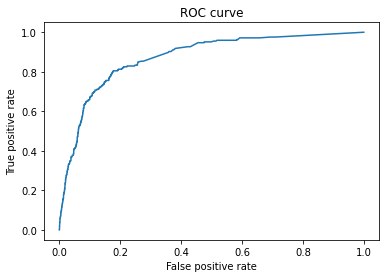

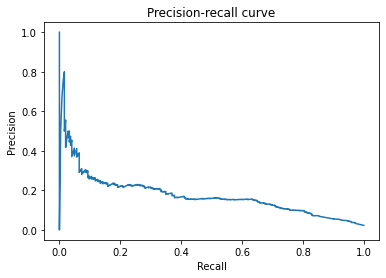

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

y_score = gb.predict(X_test)
y_pred = gb.predict_proba(X_test)[:, 1]
print(confusion_matrix(y_test, y_score))
print(classification_report(y_test, y_score))
fpr, tpr, auc_th = roc_curve(y_test, y_pred)
precision, recall, pr_th = precision_recall_curve(y_test, y_pred)

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.show()

In [12]:
feat_imp = pd.DataFrame({'feature': train_df.drop(columns=['patientunitstayid', 'aki_label']).columns , 'importance': gb.feature_importances_})
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp

,feature,importance
35,max_result_creatinine,0.412050
55,unitdischargestatus_alive,0.040930
18,min_result_calcium,0.035532
40,delta_result_BUN,0.026277
36,max_result_glucose,0.016806
...,...,...
66,unittype_CTICU,0.000000
64,unittype_CCU-CTICU,0.000000
62,ethnicity_Native American,0.000000
56,gender_Female,0.000000


Text(0.5, 1.0, 'Feature importance')

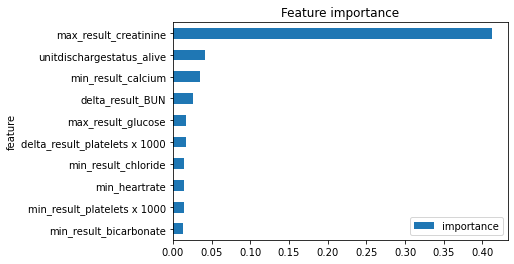

In [13]:
feat_imp[:10].sort_values(by='importance', ascending=True).plot.barh(y='importance', x='feature')
plt.title('Feature importance')

In [18]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 17
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.83815	train-auc:0.82610
[1]	eval-auc:0.84817	train-auc:0.84010
[2]	eval-auc:0.86322	train-auc:0.85134
[3]	eval-auc:0.86159	train-auc:0.85333
[4]	eval-auc:0.86433	train-auc:0.86093
[5]	eval-auc:0.86637	train-auc:0.86211
[6]	eval-auc:0.86876	train-auc:0.86551
[7]	eval-auc:0.87068	train-auc:0.86669
[8]	eval-auc:0.87035	train-auc:0.86986
[9]	eval-auc:0.87367	train-auc:0.87187
[10]	eval-auc:0.87317	train-auc:0.87294
[11]	eval-auc:0.87361	train-auc:0.87519
[12]	eval-auc:0.87494	train-auc:0.87665
[13]	eval-auc:0.87589	train-auc:0.87790
[14]	eval-auc:0.87692	train-auc:0.87890
[15]	eval-auc:0.87656	train-auc:0.87936
[16]	eval-auc:0.87808	train-auc:0.88052


In [19]:
ypred = bst.predict(dtest)

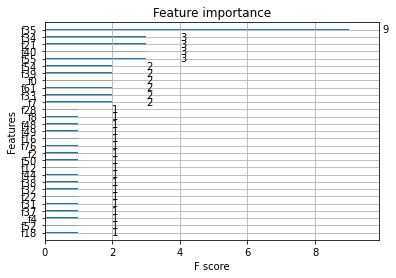

In [20]:
xgb.plot_importance(bst)

class xgboost.DMatrix(data, label=None, weight=None, base_margin=None, missing=None, silent=False, feature_names=None, feature_types=None, nthread=None)
Bases: object

Data Matrix used in XGBoost.

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. You can construct DMatrix from numpy.arrays

Parameters
* data (os.PathLike/string/numpy.array/scipy.sparse/pd.DataFrame/) – dt.Frame/cudf.DataFrame/cupy.array/dlpack Data source of DMatrix. When data is string or os.PathLike type, it represents the path libsvm format txt file, csv file (by specifying uri parameter ‘path_to_csv?format=csv’), or binary file that xgboost can read from.
* label (list, numpy 1-D array or cudf.DataFrame, optional) – Label of the training data.
* missing (float, optional) – Value in the input data which needs to be present as a missing value. If None, defaults to np.nan.
* weight (list, numpy 1-D array or cudf.DataFrame , optional) – Weight for each instance.
* silent (boolean, optional) – Whether print messages during construction
* feature_names (list, optional) – Set names for features.
* feature_types (list, optional) – Set types for features.
* nthread (integer, optional) – Number of threads to use for loading data when parallelization is applicable. If -1, uses maximum threads available on the system.

class xgboost.XGBClassifier(objective='binary:logistic', **kwargs)
Bases: xgboost.sklearn.XGBModel, object

Implementation of the scikit-learn API for XGBoost classification.

Parameters
* max_depth (int) – Maximum tree depth for base learners.
* learning_rate (float) – Boosting learning rate (xgb’s “eta”)
* verbosity (int) – The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
* objective (string or callable) – Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).
* booster (string) – Specify which booster to use: gbtree, gblinear or dart.
* tree_method (string) – Specify which tree method to use. Default to auto. If this parameter is set to default, XGBoost will choose the most conservative option available. It’s recommended to study this option from parameters document.
* n_jobs (int) – Number of parallel threads used to run xgboost.
* gamma (float) – Minimum loss reduction required to make a further partition on a leaf node of the tree.
* min_child_weight (int) – Minimum sum of instance weight(hessian) needed in a child.
* max_delta_step (int) – Maximum delta step we allow each tree’s weight estimation to be.
* subsample (float) – Subsample ratio of the training instance.
* colsample_bytree (float) – Subsample ratio of columns when constructing each tree.
* colsample_bylevel (float) – Subsample ratio of columns for each level.
* colsample_bynode (float) – Subsample ratio of columns for each split.
* reg_alpha (float (xgb's alpha)) – L1 regularization term on weights
* reg_lambda (float (xgb's lambda)) – L2 regularization term on weights
* scale_pos_weight (float) – Balancing of positive and negative weights.
* base_score – The initial prediction score of all instances, global bias.
* random_state (int) – Random number seed.

In [24]:
feature_names = train_df.drop(columns=['patientunitstayid', 'aki_label']).columns.tolist()

dtrain = xgb.DMatrix(X_train_val, label=y_train_val, feature_names = feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names = feature_names)

In [33]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import average_precision_score, make_scorer

weight = (y_train_val==0).sum()/(y_train_val==1).sum()
xgbc = xgb.XGBClassifier(scale_pos_weight=weight, objective='binary:logistic', \
                             random_state=random_state)


# Define our search space for grid search
search_space = [
  {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': range(3, 10),
    'colsample_bytree': [i/10.0 for i in range(1, 3)],
    'gamma': [i/10.0 for i in range(3)]
  }
]
# Define cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
# AUC and average precision as score
scoring = {'AUC':'roc_auc', 'Average precision':make_scorer(average_precision_score)}
# Define grid search
grid = GridSearchCV(
  xgbc,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='Average precision',
  verbose=1,
  n_jobs=-1
)
# Fit grid search
model = grid.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 64.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 94.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 132.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 196.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 445.0min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 463.8min finished


In [ ]:
464/60

In [45]:
predict = model.predict(X_test)
print('Best AUC Score: {}'.format(model.best_score_))
print('Average precision: {}'.format(average_precision_score(y_test, predict)))
print(confusion_matrix(y_test,predict, normalize='true'))

Best AUC Score: 0.088229806274818
Average precision: 0.07777970451266503
[[0.84201923 0.15798077]
 [0.27235772 0.72764228]]


In [42]:
print("Best: %f using %s" % (model.best_score_, model.best_params_))

Best: 0.088230 using {'colsample_bytree': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}


<ErrorbarContainer object of 3 artists>

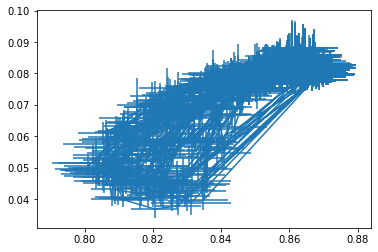

In [41]:
mean_auc = model.cv_results_['mean_test_AUC']
std_auc = model.cv_results_['std_test_AUC']
mean_ap = model.cv_results_['mean_test_Average precision']
std_ap = model.cv_results_['std_test_Average precision']
plt.errorbar(mean_auc, mean_ap, yerr=std_ap, xerr=std_auc)

In [47]:
best_params = {'colsample_bytree': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, \
               'max_depth': 5, 'n_estimators': 150, 'random_state':random_state, 'objective':'binary:logistic'}
xgbc = xgb.XGBClassifier(**best_params)
xgbc.fit(X_train_val, y_train_val)
y_pred = xgbc.predict(X_test)

print('AUC: ', roc_auc_score(y_test, y_pred))
print('Average precision: ', average_precision_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

AUC:  0.5140353345841151
Average precision:  0.04055765473542905
[[10396     4]
 [  239     7]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10400
           1       0.64      0.03      0.05       246

    accuracy                           0.98     10646
   macro avg       0.81      0.51      0.52     10646
weighted avg       0.97      0.98      0.97     10646

